# Chapter 9. Markov Chain Monte Carlo

In [1]:
import inspect

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax, ops
import jax.numpy as np
from jax.random import PRNGKey, fold_in

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, init_to_value
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
npyro.set_host_device_count(4)

### Code 9.1

In [2]:
num_weeks = int(1e5)
positions = np.repeat(0, num_weeks)
current = 10

def body_fn(i, val):
    positions, current = val
    # record current position
    positions = ops.index_update(positions, i, current)

    # flip coin to generate proposal
    bern = dist.Bernoulli(0.5).sample(fold_in(PRNGKey(0), i))
    proposal = current + (bern * 2 - 1)
    # now make sure he loops around the archipelago
    proposal = np.where(proposal < 1, 10, proposal)
    proposal = np.where(proposal > 10, 1, proposal)

    # move?
    prob_move = proposal / current
    unif = dist.Uniform().sample(fold_in(PRNGKey(1), i))
    current = np.where(unif < prob_move, proposal, current)
    return positions, current

positions, current = lax.fori_loop(0, num_weeks, body_fn, (positions, current))

### Code 9.2

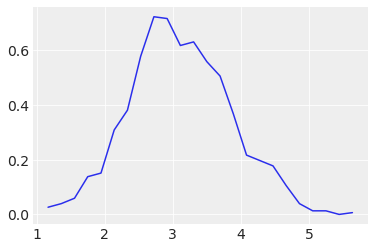

In [3]:
D = 10
T = int(1e3)
Y = dist.MultivariateNormal(np.repeat(0, D), np.identity(D)).sample(
    PRNGKey(0), (T,))
rad_dist = lambda Y: np.sqrt(np.sum(Y ** 2))
Rd = lax.map(lambda i: rad_dist(Y[i]), np.arange(T))
az.plot_kde(Rd, bw=0.18);

### Code 9.3

In [4]:
# U needs to return neg-log-probability
def myU4(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    logprob_y = np.sum(dist.Normal(muy, 1).log_prob(y))
    logprob_x = np.sum(dist.Normal(mux, 1).log_prob(x))
    logprob_muy = dist.Normal(a, b).log_prob(muy)
    logprob_mux = dist.Normal(k, d).log_prob(mux)
    U = logprob_y + logprob_x + logprob_muy + logprob_mux
    return -U

### Code 9.4

In [5]:
# gradient function
# need vector of partial derivatives of U with respect to vector q
def myU_grad4(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    G1 = np.sum(y - muy) + (a - muy) / b ** 2  # dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b ** 2  # dU/dmux
    return np.stack([-G1, -G2])  # negative bc energy is neg-log-prob

# test data
with npyro.handlers.seed(rng=7):
    y = npyro.sample("y", dist.Normal(), sample_shape=(50,))
    x = npyro.sample("x", dist.Normal(), sample_shape=(50,))
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)

### Code 9.5

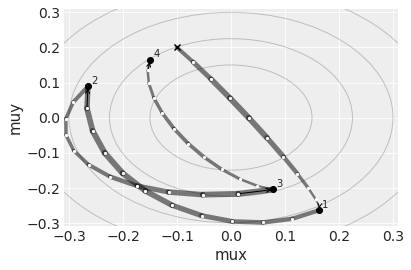

In [6]:
def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.full((L + 1, q.shape[0]), np.nan)
    ptraj = qtraj
    qtraj = ops.index_update(qtraj, 0, current_q)
    ptraj = ops.index_update(ptraj, 0, p)

    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ops.index_update(ptraj, i + 1, p)
        qtraj = ops.index_update(qtraj, i + 1, q)

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ops.index_update(ptraj, L, p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(fold_in(rng, 1))
    if runif < np.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject
    return {"q": new_q, "traj": qtraj, "ptraj": ptraj, "accept": accept,
            "dH": proposed_U + proposed_K - (current_U + current_K)}

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.31
plt.subplot(ylabel="muy", xlabel="mux", xlim=(-pr, pr), ylim=(-pr, pr))
step = 0.03
L = 11  # 0.03/28 for U-turns --- 11 for working example
n_samples = 4
path_col = (0, 0, 0, 0.5)
for r in 0.075 * np.arange(2, 6):
    plt.gca().add_artist(plt.Circle((0, 0), r, alpha=0.2, fill=False))
plt.scatter(Q["q"][0], Q["q"][1], c="k", marker="x", zorder=4)
for i in range(n_samples):
    Q = HMC2(myU4, myU_grad4, step, L, Q["q"], fold_in(PRNGKey(0), i))
    if n_samples < 10:
        for j in range(L):
            K0 = np.sum(Q["ptraj"][j] ** 2) / 2
            plt.plot(Q["traj"][j:j + 2, 0], Q["traj"][j:j + 2, 1],
                     c=path_col, lw=1 + 2 * K0)
        plt.scatter(Q["traj"][:, 0], Q["traj"][:, 1], c="white", s=5, zorder=3)
        # for fancy arrows
        dx = Q["traj"][L, 0] - Q["traj"][L - 1, 0]
        dy = Q["traj"][L, 1] - Q["traj"][L - 1, 1]
        d = np.sqrt(dx ** 2 + dy ** 2)
        plt.annotate("", (Q["traj"][L - 1, 0], Q["traj"][L - 1, 1]),
                     (Q["traj"][L, 0], Q["traj"][L, 1]),
                     arrowprops={"arrowstyle": "<-"})
        plt.annotate(str(i + 1), (Q["traj"][L, 0], Q["traj"][L, 1]),
                     xytext=(3, 3), textcoords="offset points")
    plt.scatter(Q["traj"][L + 1, 0], Q["traj"][L + 1, 1],
                c=("red" if np.abs(Q["dH"]) > 0.1 else "black"), zorder=4)

### Code 9.6

In [7]:
source_HMC2 = inspect.getsourcelines(HMC2)
print(''.join(''.join(source_HMC2[0]).split("\n\n")[0]))

def HMC2(U, grad_U, epsilon, L, current_q, rng):
    q = current_q
    # random flick - p is momentum
    p = dist.Normal(0, 1).sample(fold_in(rng, 0), (q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.full((L + 1, q.shape[0]), np.nan)
    ptraj = qtraj
    qtraj = ops.index_update(qtraj, 0, current_q)
    ptraj = ops.index_update(ptraj, 0, p)


### Code 9.7

In [8]:
print(''.join(''.join(source_HMC2[0]).split("\n\n")[1]))

    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            p = p - epsilon * grad_U(q)
            ptraj = ops.index_update(ptraj, i + 1, p)
        qtraj = ops.index_update(qtraj, i + 1, q)


### Code 9.8

In [9]:
print(''.join(''.join(source_HMC2[0]).split("\n\n")[2]))

    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj = ops.index_update(ptraj, L, p)
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = np.sum(current_p ** 2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p ** 2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = dist.Uniform().sample(fold_in(rng, 1))
    if runif < np.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject
    return {"q": new_q, "traj": qtraj, "ptraj": ptraj, "accept": accept,
            "dH": proposed_U + proposed_K - (current_U + current_K)}



### Code 9.9

In [10]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged
d["log_gdp"] = d["rgdppc_2000"].pipe(onp.log)
dd = d[d["rgdppc_2000"].notnull()].copy()
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

### Code 9.10

In [11]:
def model(cid, rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3), sample_shape=(2,))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_5, optim.Adam(0.1), AutoContinuousELBO(),
          cid=dd.cid.values, rugged_std=dd.rugged_std.values,
          log_gdp_std=dd.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_5 = svi.get_params(state)
post = m8_5.sample_posterior(PRNGKey(1), p8_5, (1000,))
summary(post, 0.89, False)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   1009.20      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    755.33      1.00
      b[0]      0.13      0.07      0.13      0.01      0.24   1045.06      1.00
      b[1]     -0.15      0.06     -0.14     -0.23     -0.05   1003.36      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    810.01      1.00




### Code 9.11

In [12]:
dat_slim = {"log_gdp_std": dd.log_gdp_std.values,
            "rugged_std": dd.rugged_std.values,
            "cid": dd.cid.values}
{k: v[:5] for k, v in dat_slim.items()}

{'log_gdp_std': array([0.87971187, 0.9647547 , 1.1662705 , 1.10448536, 0.91490375]),
 'rugged_std': array([0.13834247, 0.55256369, 0.12399226, 0.12495969, 0.43340858]),
 'cid': array([0, 1, 1, 1, 1], dtype=int32)}

### Code 9.12

In [13]:
def model(cid, rugged_std, log_gdp_std):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3), sample_shape=(2,))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m9_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m9_1.run(PRNGKey(0), **dat_slim)

sample: 100%|██████████| 1000/1000 [00:05<00:00, 185.90it/s, 7 steps of size 7.54e-01. acc. prob=0.89]


### Code 9.13

In [14]:
m9_1.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.01      0.89      0.87      0.91    550.23      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07    945.17      1.00
      b[0]      0.14      0.07      0.14      0.01      0.25    471.73      1.00
      b[1]     -0.14      0.05     -0.14     -0.21     -0.04    692.05      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    592.05      1.00




### Code 9.14

In [15]:
def model(cid, rugged_std, log_gdp_std):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3), sample_shape=(2,))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m9_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m9_1.run(PRNGKey(0), **dat_slim)

### Code 9.15

In [16]:
print(''.join(inspect.getsourcelines(m9_1.sampler.model)[0]))

def model(cid, rugged_std, log_gdp_std):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3), sample_shape=(2,))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)



### Code 9.16

In [17]:
m9_1.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   2506.78      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07   2685.63      1.00
      b[0]      0.13      0.08      0.13      0.01      0.26   2247.60      1.00
      b[1]     -0.14      0.06     -0.14     -0.22     -0.05   2542.77      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   2173.55      1.00




### Code 9.17

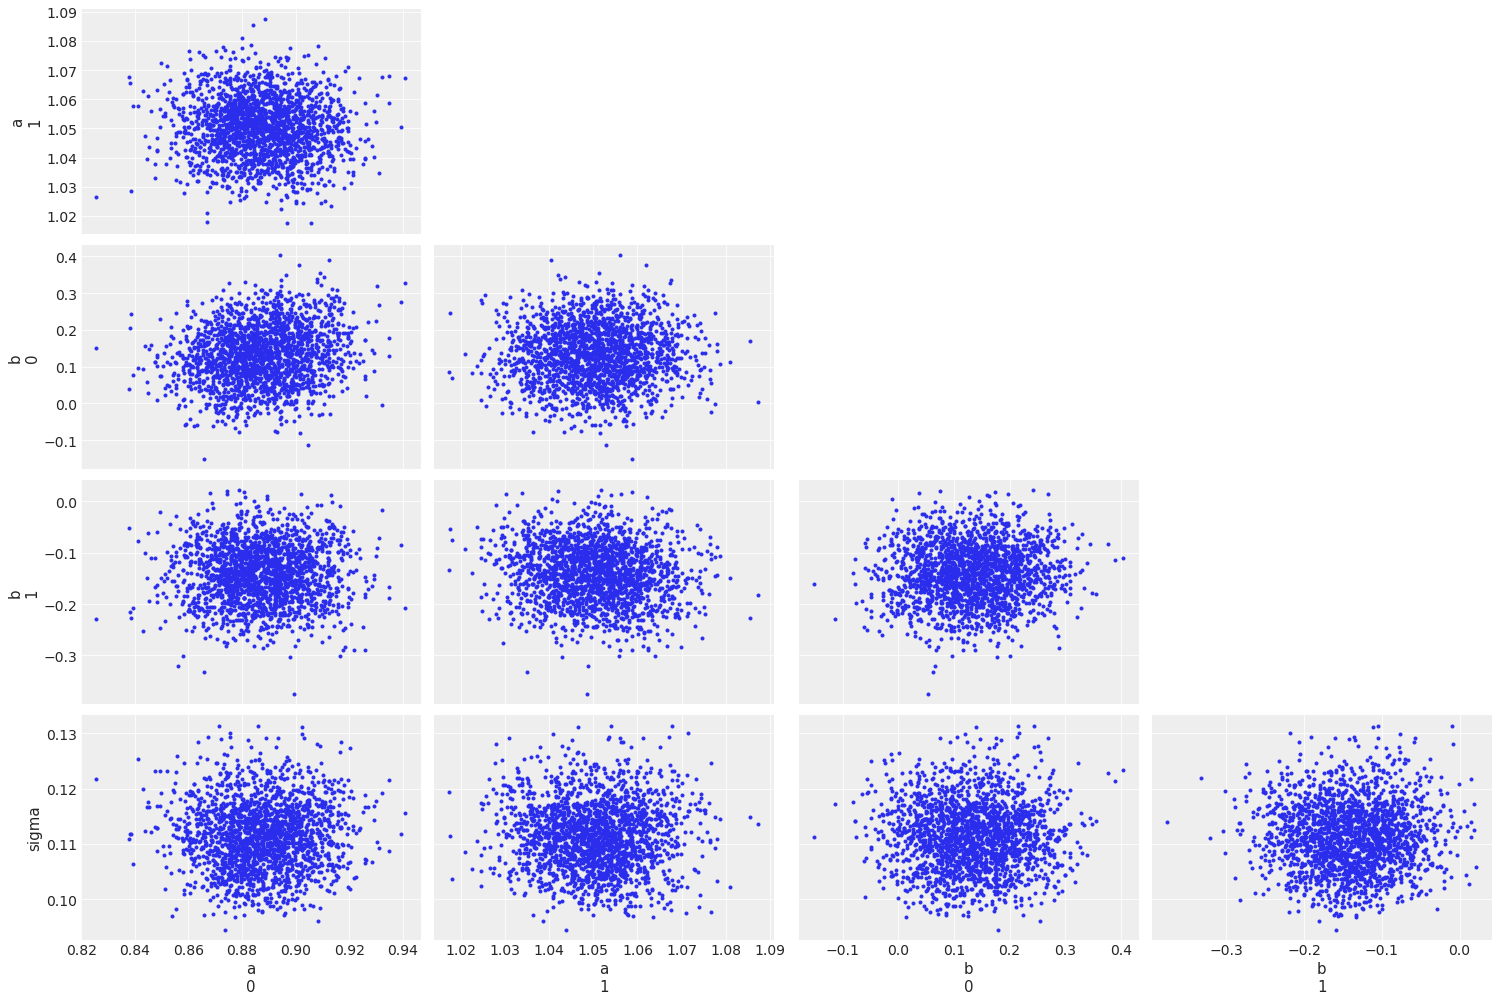

In [18]:
az.plot_pair(az.from_numpyro(m9_1));

### Code 9.18

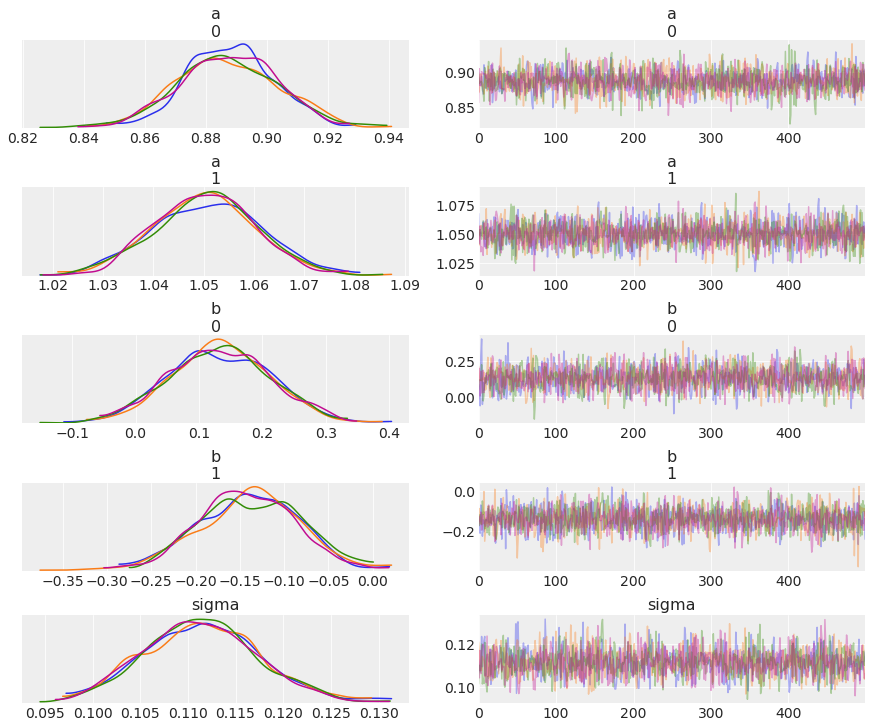

In [19]:
az.plot_trace(az.from_numpyro(m9_1));

### Code 9.19

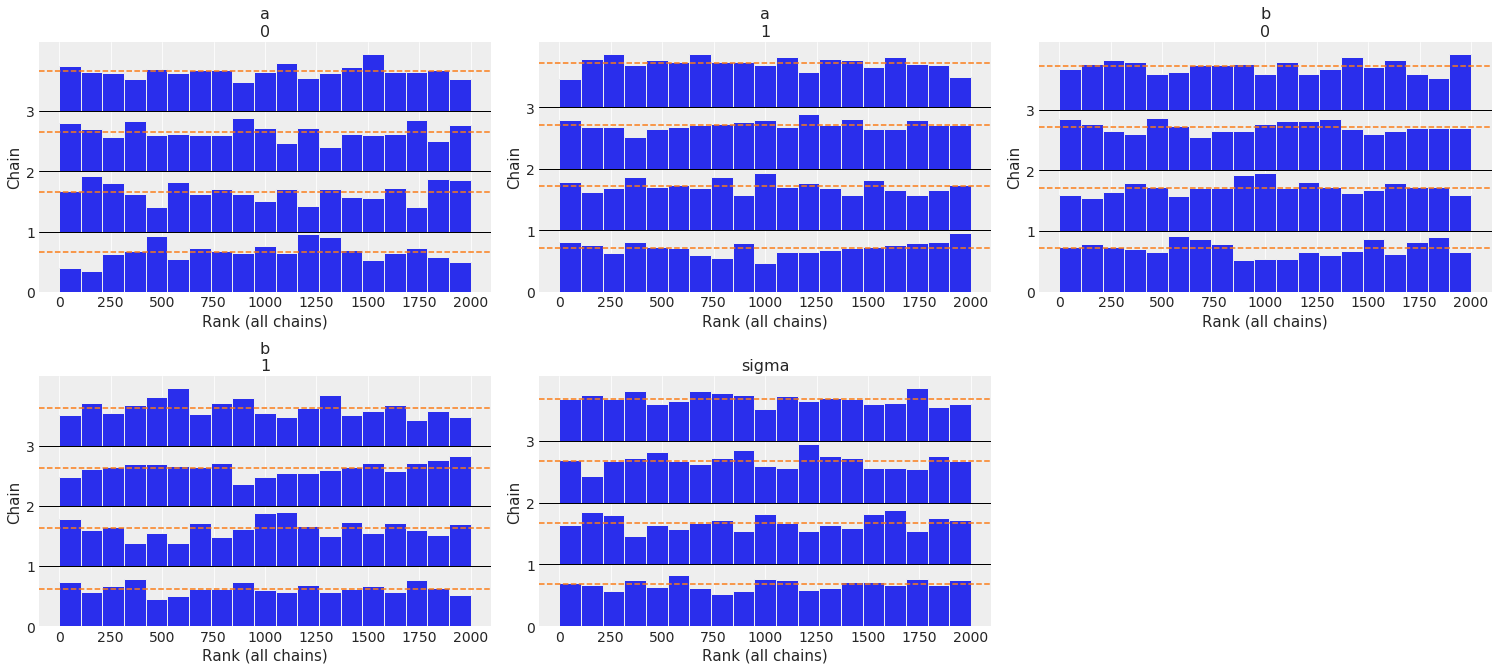

In [20]:
az.plot_rank(az.from_numpyro(m9_1));

### Code 9.20

In [21]:
y = np.array([-1, 1])

def model(y):
    alpha = npyro.sample("alpha", dist.Normal(0, 1000))
    sigma = npyro.sample("sigma", dist.Exponential(0.0001))
    mu = alpha
    npyro.sample("y", dist.Normal(mu, sigma), obs=y)

m9_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=2)
m9_2.run(PRNGKey(11), extra_fields=["diverging"], y=y)

### Code 9.21

In [22]:
m9_2.print_summary(0.89)
print("num_diverging:", m9_2.get_extra_fields()['diverging'].sum())



                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha     38.81    365.78      6.97   -283.38    573.54     66.55      1.04
     sigma    591.38   1470.46    118.58      8.93   1258.89    113.87      1.01


num_diverging: 85


### Code 9.22

In [23]:
y = np.array([-1, 1])

def model(y):
    alpha = npyro.sample("alpha", dist.Normal(1, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = alpha
    npyro.sample("y", dist.Normal(mu, sigma), obs=y)

m9_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=2)
m9_3.run(PRNGKey(11), y=y)
m9_3.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
     alpha      0.16      1.44      0.07     -1.82      1.73    165.24      1.00
     sigma      1.59      0.95      1.35      0.50      2.60    112.25      1.02




### Code 9.23

In [24]:
y = dist.Normal(loc=0, scale=1).sample(PRNGKey(41), (100,))

### Code 9.24

In [25]:
def model(y):
    a1 = npyro.sample("a1", dist.Normal(0, 1000))
    a2 = npyro.sample("a2", dist.Normal(0, 1000))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a1 + a2
    npyro.sample("y", dist.Normal(mu, sigma), obs=y)

m9_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=2)
m9_4.run(PRNGKey(0), extra_fields=["num_steps"], y=y)
m9_4.print_summary()
print("num_max_tree_depth:",
      (m9_4.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum())



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1    276.76    227.79    273.36   -101.25    596.39      7.88      1.30
        a2   -276.64    227.80   -273.21   -596.09    101.31      7.88      1.30
     sigma      1.16      0.11      1.16      0.97      1.32     13.52      1.03


num_max_tree_depth: 756


### Code 9.25

In [26]:
def model(y):
    a1 = npyro.sample("a1", dist.Normal(0, 10))
    a2 = npyro.sample("a2", dist.Normal(0, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a1 + a2
    npyro.sample("y", dist.Normal(mu, sigma), obs=y)

m9_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=2)
m9_4.run(PRNGKey(0), y=y)
m9_4.print_summary(0.89)



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        a1     -0.51      6.73     -0.68    -10.98      9.73    193.99      1.01
        a2      0.63      6.73      0.79     -9.40     11.24    193.45      1.01
     sigma      1.15      0.09      1.15      1.02      1.27    249.89      1.00




### Code 9.26

In [27]:
def model(y):
    npyro.sample("a", dist.Normal(0, 1))
    npyro.sample("b", dist.Cauchy(0, 1))

kernel = NUTS(model, init_strategy=init_to_value({"a": 0., "b": 0.}))
mp = MCMC(kernel, num_warmup=100, num_samples=9900)
mp.run(PRNGKey(0), y=1)

sample: 100%|██████████| 10000/10000 [00:08<00:00, 1178.44it/s, 7 steps of size 1.98e-01. acc. prob=0.91]


### Code 9.27

In [28]:
N = 100  # number of individuals
# sim total height of each
height = dist.Normal(10, 2).sample(PRNGKey(0), (N,))
# leg as proportion of height
leg_prop = dist.Uniform(0.4, 0.5).sample(PRNGKey(1), (N,))
# sim left leg as proportion + error
leg_left = leg_prop * height + dist.Normal(0, 0.02).sample(PRNGKey(2), (N,))
# sim right leg as proportion + error
leg_right = leg_prop * height + dist.Normal(0, 0.02).sample(PRNGKey(3), (N,))
# combine into data frame
d = pd.DataFrame(
    {"height": height, "leg_left": leg_left, "leg_right": leg_right})

### Code 9.28

In [29]:
def model(leg_left, leg_right, height):
    a = npyro.sample("a", dist.Normal(10, 100))
    bl = npyro.sample("bl", dist.Normal(2, 10))
    br = npyro.sample("br", dist.Normal(2, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    npyro.sample("height", dist.Normal(mu, sigma), obs=height)

kernel = NUTS(model, init_strategy=init_to_value(
    {"a": 10., "bl": 0., "br": 0., "sigma": 1.}))
m5_8s = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
m5_8s.run(PRNGKey(0), **dict(zip(d.columns, d.T.values)))

### Code 9.29

In [30]:
def model(leg_left, leg_right, height):
    a = npyro.sample("a", dist.Normal(10, 100))
    bl = npyro.sample("bl", dist.Normal(2, 10))
    br = npyro.sample("br", dist.TruncatedNormal(0, 2, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    npyro.sample("height", dist.Normal(mu, sigma), obs=height)

kernel = NUTS(model, init_strategy=init_to_value(
    {"a": 10., "bl": 0., "br": 0.1, "sigma": 1.}))
m5_8s2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
m5_8s2.run(PRNGKey(0), **dict(zip(d.columns, d.T.values)))